In [1]:
from music21 import stream, interval, corpus, converter, instrument
from music21 import note, chord, environment, duration, clef
import notebook
from datetime import date, timedelta
import pandas as pd
import pathlib
import numpy as np

In [2]:
class Utils(object):
    
    @staticmethod
    def get_score(self, file_path:str) -> stream.Score:
        score = None
        file_info = music.Utils.get_file_info(file_path)
        if file_info['Path'].exists():
                score = converter.parse(file_info['path_text'])
        return score
    
    #
    # get intervals for a Part
    #
    @staticmethod
    def get_part_intervals(apart)-> [dict]:
        intrvals = []
        part_notes = apart.flat.getElementsByClass('Note')
        for ind in range(len(part_notes)-1):
            n1 = part_notes[ind]
            n2 = part_notes[ind+1]
            i = interval.Interval(n1, n2)
            idict = {'note1':n1, 'note2':n2, 'interval':i}
            intrvals.append(idict)
        return intrvals
    
    @staticmethod
    def get_part_notes(apart) -> [note.Note]:
        part_notes = apart.flat.getElementsByClass('Note')
        return part_notes
    
    @staticmethod
    def get_score_intervals(ascore, partname=None):
        """ Get the intervals for all Parts of a Score as a dict
        
        """
        parts = ascore.getElementsByClass(stream.Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                pdict[pname] = Utils.get_part_intervals(p)
        return pdict
    
    @staticmethod
    def get_score_notes(ascore, partname=None):
        """Get the Notes for all Parts or the named part of a Score as a dict
        
        Note that this does not return Rest or Chord objects
        """
        
        parts = ascore.getElementsByClass(stream.Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                notes = Utils.get_part_notes(p)
                pdict[pname] = notes
        return pdict
    
    
    @staticmethod
    def get_intervals_for_score(ascore:stream.Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,[str],[int]):
        """Get the intervals of all Parts of a Score as a pandas.DataFrame
        
        DataFrame columns returned:
            interval  (interval.Interval)
            part_name
            part_number
            note1  (note.Note the first Note in the interval pair)
            note2  (note.Note the second Note in the interval pair)
            name (interval name as in "P5")
            directedName  (as in "P-5" for down a 5th)
            niceName
            semitones (int)
        
        Returns a 3-tuplet consisting of the intervals_df DataFrame,
        a [int] of part numbers, and a [str] of part names.
        """
        pdict = Utils.get_score_intervals(ascore)
        intrvals_df = pd.DataFrame()
        part_number = 1
        score_partnames = set()
        score_partnumbers = set()
        for k in pdict.keys():  # part names
                if (partnames is None or k in partnames) or (partnumbers is None or part_number in partnumbers):
                    part_intervals = pdict[k]
                    intervals =  [x['interval'] for x in part_intervals]
                    df = pd.DataFrame(data=intervals, columns=['interval'])
                    df['part_number'] = part_number
                    df['part_name'] = k
                    df['note1'] = [x['note1'] for x in part_intervals]
                    df['note2'] = [x['note2'] for x in part_intervals]
                    score_partnames.add(k)
                    score_partnumbers.add(part_number)
                    intrvals_df = intrvals_df.append(df)
                    part_number = part_number + 1
    
        intrvals_df['name'] = [x.name for x in intrvals_df['interval']]
        intrvals_df['directedName'] = [x.directedName for x in intrvals_df['interval']]
        intrvals_df['niceName'] = [x.niceName for x in intrvals_df['interval']]
        intrvals_df['semitones'] = [x.semitones for x in intrvals_df['interval']]
        return intrvals_df, score_partnames, score_partnumbers
    
    @staticmethod
    def get_notes_for_score(ascore, partnames=None, partnumbers=None):
        """Get the Notes of all Parts from a score as a pandas.DataFrame
        
        DataFrame columns returned:
            part_name
            part_number
            Note (music21.note.Note)
            name
            nameWithOctave
            pitch (music21.pitch.Pitch)
            duration (music21.duration.Duration)
            pitchClass (int)
        
        Returns a 3-tuplet consisting of the notes_df DataFrame,
        an interger list of part numbers, and a str list of part names.
        """
        pdict = Utils.get_score_notes(ascore)
        notes_df = pd.DataFrame()
        part_number = 1
        score_partnames = set()
        score_partnumbers = set()
        for k in pdict.keys():
            if (partnames is None or k in partnames) or (partnumbers is None or part_number in partnumbers):
                df = pd.DataFrame(data=pdict[k], columns=['note'])
                df['part_number'] = part_number
                df['part_name'] = k
                score_partnames.add(k)
                score_partnumbers.add(part_number)
                notes_df = notes_df.append(df)
                part_number = part_number + 1
        
        notes_df['name'] = [x.name for x in notes_df['note']]
        notes_df['nameWithOctave'] = [x.nameWithOctave for x in notes_df['note']]
        notes_df['pitch'] = [x.pitch for x in notes_df['note']]
        notes_df['duration'] = [x.duration for x in notes_df['note']]
        notes_df['pitchClass'] = [x.pitch.pitchClass for x in notes_df['note']]
        return notes_df, score_partnames, score_partnumbers
    
    @staticmethod
    def get_durations_from_notes(source_df:pd.DataFrame) -> pd.DataFrame:
        """Get the Durations from a notes or intervals DataFrame
        
        The notes_df argument has the columns described in get_notes_for_score().
        DataFrame columns returned:
            Note (music21.note.Note)
            duration (music21.duration.Duration)
            type
            ordinal
            dots
            fullName
            quarterLength
            tuplets
        See the music21.duration documentation for details on individual fields
        """
        if 'duration' in source_df.columns:
            notes_df = source_df
            durations_df = pd.DataFrame(data=notes_df[['note','duration']], columns=['note','duration'])
            durations_df['type'] = [x.type for x in notes_df['duration']]
            durations_df['ordinal'] = [x.ordinal for x in notes_df['duration']]
            durations_df['dots'] = [x.dots for x in notes_df['duration']]
            durations_df['fullName'] = [x.fullName for x in notes_df['duration']]
            durations_df['quarterLength'] = [x.quarterLength for x in notes_df['duration']]
            durations_df['tuplets'] = [x.tuplets for x in notes_df['duration']]
        else:
            intervals_df = source_df
            durations_df = pd.DataFrame(data=intervals_df[['note1']], columns=['note1'])
            durations_df['duration'] = [x.duration for x in intervals_df['note1']]
            durations_df['type'] = [x.duration.type for x in intervals_df['note1']]
            durations_df['ordinal'] = [x.duration.ordinal for x in intervals_df['note1']]
            durations_df['dots'] = [x.duration.dots for x in intervals_df['note1']]
            durations_df['fullName'] = [x.duration.fullName for x in intervals_df['note1']]
            durations_df['quarterLength'] = [x.duration.quarterLength for x in intervals_df['note1']]
            durations_df['tuplets'] = [x.duration.tuplets for x in intervals_df['note1']]
            durations_df.rename(columns={'note1':'note'}, inplace=True)
        return durations_df
    
    @staticmethod
    def get_metadata_bundle(composer=None, title=None):
        meta = None
        if composer is not None:
            meta = corpus.search(composer,'composer')
            if title is not None:
                meta = meta.intersection(corpus.search(title,'title'))
        elif title is not None:
            meta = corpus.search(title,'title')
        return meta
        
    @staticmethod
    def get_all_score_intervals(composer=None, title=None, partnames=None, partnumbers=None):
        meta = Utils.get_metadata_bundle(composer, title)
        intrvals_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(meta)):
            md = meta[i].metadata
            score = corpus.parse(meta[i])
            df,pnames,pnums = Utils.get_intervals_for_score(score, partnames, partnumbers)
            df['title'] = md.title
            intrvals_df = intrvals_df.append(df)
            all_score_partnames = all_score_partnames.union(pnames)
            all_score_partnumbers = all_score_partnumbers.union(pnums)
        return intrvals_df, all_score_partnames, all_score_partnumbers

    @staticmethod
    def get_all_score_notes(composer=None, title=None, partnames=None, partnumbers=None):
        meta = Utils.get_metadata_bundle(composer, title)
        notes_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(meta)):
            md = meta[i].metadata
            score = corpus.parse(meta[i])
            df,pnames,pnums = Utils.get_notes_for_score(score, partnames, partnumbers)
            df['title'] = md.title
            notes_df = notes_df.append(df)
            all_score_partnames = all_score_partnames.union(pnames)
            all_score_partnumbers = all_score_partnumbers.union(pnums)
        return notes_df, all_score_partnames, all_score_partnumbers

    @staticmethod
    def show_measures(measures, how='text'):
        nmeasures = len(measures)
        print(f"number of measures: {nmeasures}")
        i = 1
        for measure in measures:
            notes = measure.getElementsByClass(['Note','Chord','Rest'])
            print('measure {}'.format(i))
            for n in notes:
                if n.isNote:
                    print(n.nameWithOctave)
                else:
                    print(n.fullName)
            i = i+1
            measure.show(how)   # if None, displays in MuseScore
    
    @staticmethod
    def show_intervals(df, what='name'):
        int_string = str(df[what].values.tolist())
        return int_string
    
    @staticmethod
    def show_notes(df, what='name'):
        note_string = str(df[what].values.tolist())
        return note_string
    
    @staticmethod
    def show_durations(df, what='quarterLength'):
        duration_string = str(df[what].values.tolist())
        return duration_string
    
    @staticmethod
    def note_info(note):
        dur = note.duration
        if note.isRest:
            info = f'name: {note.name}, fullName: {note.fullName}, type: {dur.type}, dots: {dur.dots},\
            quarterLength: {dur.quarterLength}'
        else:
            info = f'{note.nameWithOctave}, type: {dur.type}, dots: {dur.dots},\
            fullName: {dur.fullName}, quarterLength: {dur.quarterLength}, tuplets: {dur.tuplets}'
        return info

    @staticmethod
    def duration_info(dur):
        info = f"type: {dur.type}, ordinal: {dur.ordinal}, dots: {dur.dots}, fullName: {dur.fullName}, quarterLength: {dur.quarterLength}, tuplets: {dur.tuplets}"
        return info
    
    @staticmethod
    def get_interval_stats(ascore, partnames=None, partnumbers=None):
        int_df,pnames,pnums = Utils.get_intervals_for_score(ascore, partnames, partnumbers)
        int_df = int_df.groupby(by=['semitones']).count()[['interval']]
        int_df.rename(columns={'interval':'count'}, inplace=True)
        int_df.reset_index(inplace=True)       
        return int_df.sort_values(by='count', ascending=False)
    
    @staticmethod
    def create_note(start_note:note.Note, 
                    anInterval:interval.Interval=None, semitones:int=None,
                    dur:duration.Duration=None, quarterLen:int=None) -> note.Note:
        """Creates a new Note a given interval away from a starting note
        
        Args:
            start_note (note.Note): the anchor Note
            interval (interval.Interval): a valid Interval or None. If None, semitones must be present.
            semitones (int): interval expressed as semitones
            duration (duration.Duration): duration to assign to the new Note
            quarterLength (int): duration to assign to the new Note expressed as quarterLength
        Returns:
            A new Note that is the specified interval away from the start_note.
        Notes:
            * duration or quarterLength may be specified, but not both.
            * if both duration and quarterLength are none, the duration of the new Note
              will be the same as the duration of start_note
        """
        new_note = copy.copy(start_note)    # shallow copy
        if anInterval is None and semitones is None:
            raise ValueError('interval and semitones cannot both be None')
        intval = anInterval
        if anInterval is None:
            intval = interval.Interval(semitones)
        new_note = new_note.transpose(intval)
        if dur is None and quarterLen is not None:
            new_note.quarterLength = quarterLen
        elif dur is not None:
            new_note.duration = dur
        return new_note
    
    @staticmethod
    def random_notes(lower_ps:int, upper_ps:int, num:int=10, minval=0.5) -> [note.Note]:
        notes = []
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps value)
            dur = random.randrange(1, 8) * minval       # random durations as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        return notes
    
    @staticmethod
    def random_part(lower_ps:int, upper_ps:int, num:int=10, minval=0.5, 
                     clef=clef.TrebleClef(), instrument=instrument.Piano()):
        # minval is given as quarterLength, 0.5 is an eighth note, 0.25 is a 16th etc.
        part = stream.Part()
        part.insert(0,instrument)
        notes = []
        notes.append(clef)
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps value) c4 to b6
            dur = random.randrange(1, 8) * minval    # random durations (multiples of 16th notes) as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        part.append(notes)
        return part
    
    #
    # breaks up a path name into component parts
    #
    @staticmethod
    def get_file_info(cpath, def_extension='mxl'):
        known_extensions = [def_extension, 'mxl','.xml','.musicxml']
        x = cpath.split("/")
        paths = x[0:len(x)-1]
        filename = x[-1]
        ext = filename.split(".")
        name = ext[0]
        if len(ext)==2 and ext[1] in known_extensions:
            ext = ext[1]
            path = cpath      
        else:
            ext = def_extension
            filename = f"{filename}.{ext}"
            path = f"{cpath}.{ext}"
        p = pathlib.Path(path)
        return  {'paths':paths, 'path_text':path, 'filename':filename, 'name':name,'extension': ext, 'Path':p}

    @staticmethod
    def round_values(x, places=5):
        if not type(x) is str:
            return round(x, places)
        else:
            return x
    
    @staticmethod
    def get_timedelta(start_date=date(1970,1,1), end_date=date.today()) -> int:
        """Gets the number of elapsed seconds between two dates.
        
        Args:
            start_date (datetime.date): the starting date. Default value is Jan 1,1970
            end_date: the ending date. Default value is today()
        Returns:
            The absolute value of the number of elapsed seconds between the two dates.
        Notes:
            Useful in setting a random seed.
        
        """
        
        delta = end_date - start_date
        return abs(int(delta.total_seconds()))


In [10]:
sBach = corpus.parse('bwv67.4')
score_intervals = Utils.get_score_intervals(sBach)
part_intervals = score_intervals['Soprano']
intervals_df, score_partnames, score_partnumbers = Utils.get_intervals_for_score(sBach, partnames=['Soprano'])
intervals_df

,interval,part_number,part_name,note1,note2,name,directedName,niceName,semitones
0,<music21.interval.Interval P1>,1,Soprano,<music21.note.Note F#>,<music21.note.Note F#>,P1,P1,Perfect Unison,0
1,<music21.interval.Interval P1>,1,Soprano,<music21.note.Note F#>,<music21.note.Note F#>,P1,P1,Perfect Unison,0
2,<music21.interval.Interval P5>,1,Soprano,<music21.note.Note F#>,<music21.note.Note C#>,P5,P5,Perfect Fifth,7
3,<music21.interval.Interval M2>,1,Soprano,<music21.note.Note C#>,<music21.note.Note D#>,M2,M2,Major Second,2
4,<music21.interval.Interval m2>,1,Soprano,<music21.note.Note D#>,<music21.note.Note E>,m2,m2,Minor Second,1
...,...,...,...,...,...,...,...,...,...
43,<music21.interval.Interval P-5>,4,Bass,<music21.note.Note A>,<music21.note.Note D>,P5,P-5,Perfect Fifth,-7
44,<music21.interval.Interval m-2>,4,Bass,<music21.note.Note D>,<music21.note.Note C#>,m2,m-2,Minor Second,-1
45,<music21.interval.Interval M-2>,4,Bass,<music21.note.Note C#>,<music21.note.Note B>,M2,M-2,Major Second,-2
46,<music21.interval.Interval M2>,4,Bass,<music21.note.Note B>,<music21.note.Note C#>,M2,M2,Major Second,2


In [4]:
durations_df = Utils.get_durations_from_notes(intervals_df)
durations_df

,note,duration,type,ordinal,dots,fullName,quarterLength,tuplets
0,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
1,<music21.note.Note F#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
2,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
3,<music21.note.Note C#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
4,<music21.note.Note D#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
...,...,...,...,...,...,...,...,...
43,<music21.note.Note A>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
44,<music21.note.Note D>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
45,<music21.note.Note C#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
46,<music21.note.Note B>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()


In [11]:
n = note.Note("F#4")
n.duration = duration.Duration(1.75)
print(Utils.note_info(n))
print(Utils.duration_info(n.duration))
print(n.classes)

F#4, type: quarter, dots: 2,            fullName: Double Dotted Quarter, quarterLength: 1.75, tuplets: ()
type: quarter, ordinal: 6, dots: 2, fullName: Double Dotted Quarter, quarterLength: 1.75, tuplets: ()
('Note', 'NotRest', 'GeneralNote', 'Music21Object', 'ProtoM21Object', 'object')


In [14]:
classinfo = interval.Interval   #note.Note
if classinfo is note.Note:
    print('Note')
elif classinfo is interval.Interval:
    print('Interval')

Interval


In [30]:
terminal_note = note.Note('c#8')
initial_note = note.Rest()
initial_note.duration.quarterLength=0
print(Utils.note_info(terminal_note))
print(Utils.note_info(initial_note))
print(terminal_note.nameWithOctave)

C#8, type: quarter, dots: 0,            fullName: Quarter, quarterLength: 1.0, tuplets: ()
name: rest, fullName: Zero Rest, type: zero, dots: 0,            quarterLength: 0.0
C#8


In [31]:
terminal_note.fullName

'C-sharp in octave 8 Quarter Note'

In [5]:
# tuplets
dur = duration.Duration(quarterLength=0.333333)
n1 = note.Note("F#4", duration=dur)
n2 = note.Note("G4", quarterLength=0.33333)
n3 = note.Note("C5", quarterLength=0.75)
print(Utils.note_info(n1))
print(Utils.note_info(n3))

F#4, type: eighth, dots: 0,        fullName: Eighth Triplet (1/3 QL), quarterLength: 1/3, tuplets: (<music21.duration.Tuplet 3/2/eighth>,)
C5, type: eighth, dots: 1,        fullName: Dotted Eighth, quarterLength: 0.75, tuplets: ()


In [8]:
p = n.pitch
#dir(p)
p.pitchClass

6

In [9]:
n.show('text')

<music21.note.Note F#>


In [10]:
n.pitch.pitchClass # C=0, C#=1, D=2, D#=3   etc.

6

In [9]:
c = chord.Chord("C4 E4 G#4")
c.isConsonant()

False

In [10]:
corpus.manager.listLocalCorporaNames()

[None, 'dwbzen']

In [11]:
localCorpus = corpus.corpora.LocalCorpus('dwbzen')
localCorpus.existsInSettings

True

In [14]:
env = environment.UserSettings()
#env.keys()

In [13]:
# corpus.getPaths()
# corpus.addPath('C:/data/music/Corpus/dwbzen','dwbzen')  # temporary for this session only
#
# uncomment below make it permanent
#
# us = environment.UserSettings()
# us['localCorpusPath'] = 'C:/data/music/Corpus/dwbzen'

In [15]:
corpus.getLocalPaths()


[WindowsPath("C:/data/music/Corpus/dwbzen/Class of '69 - I. Prelude.mxl"),
 WindowsPath("C:/data/music/Corpus/dwbzen/Class of '69 - II. Walking Dead Waltz.mxl")]

### Bach chorale BWV 57.8

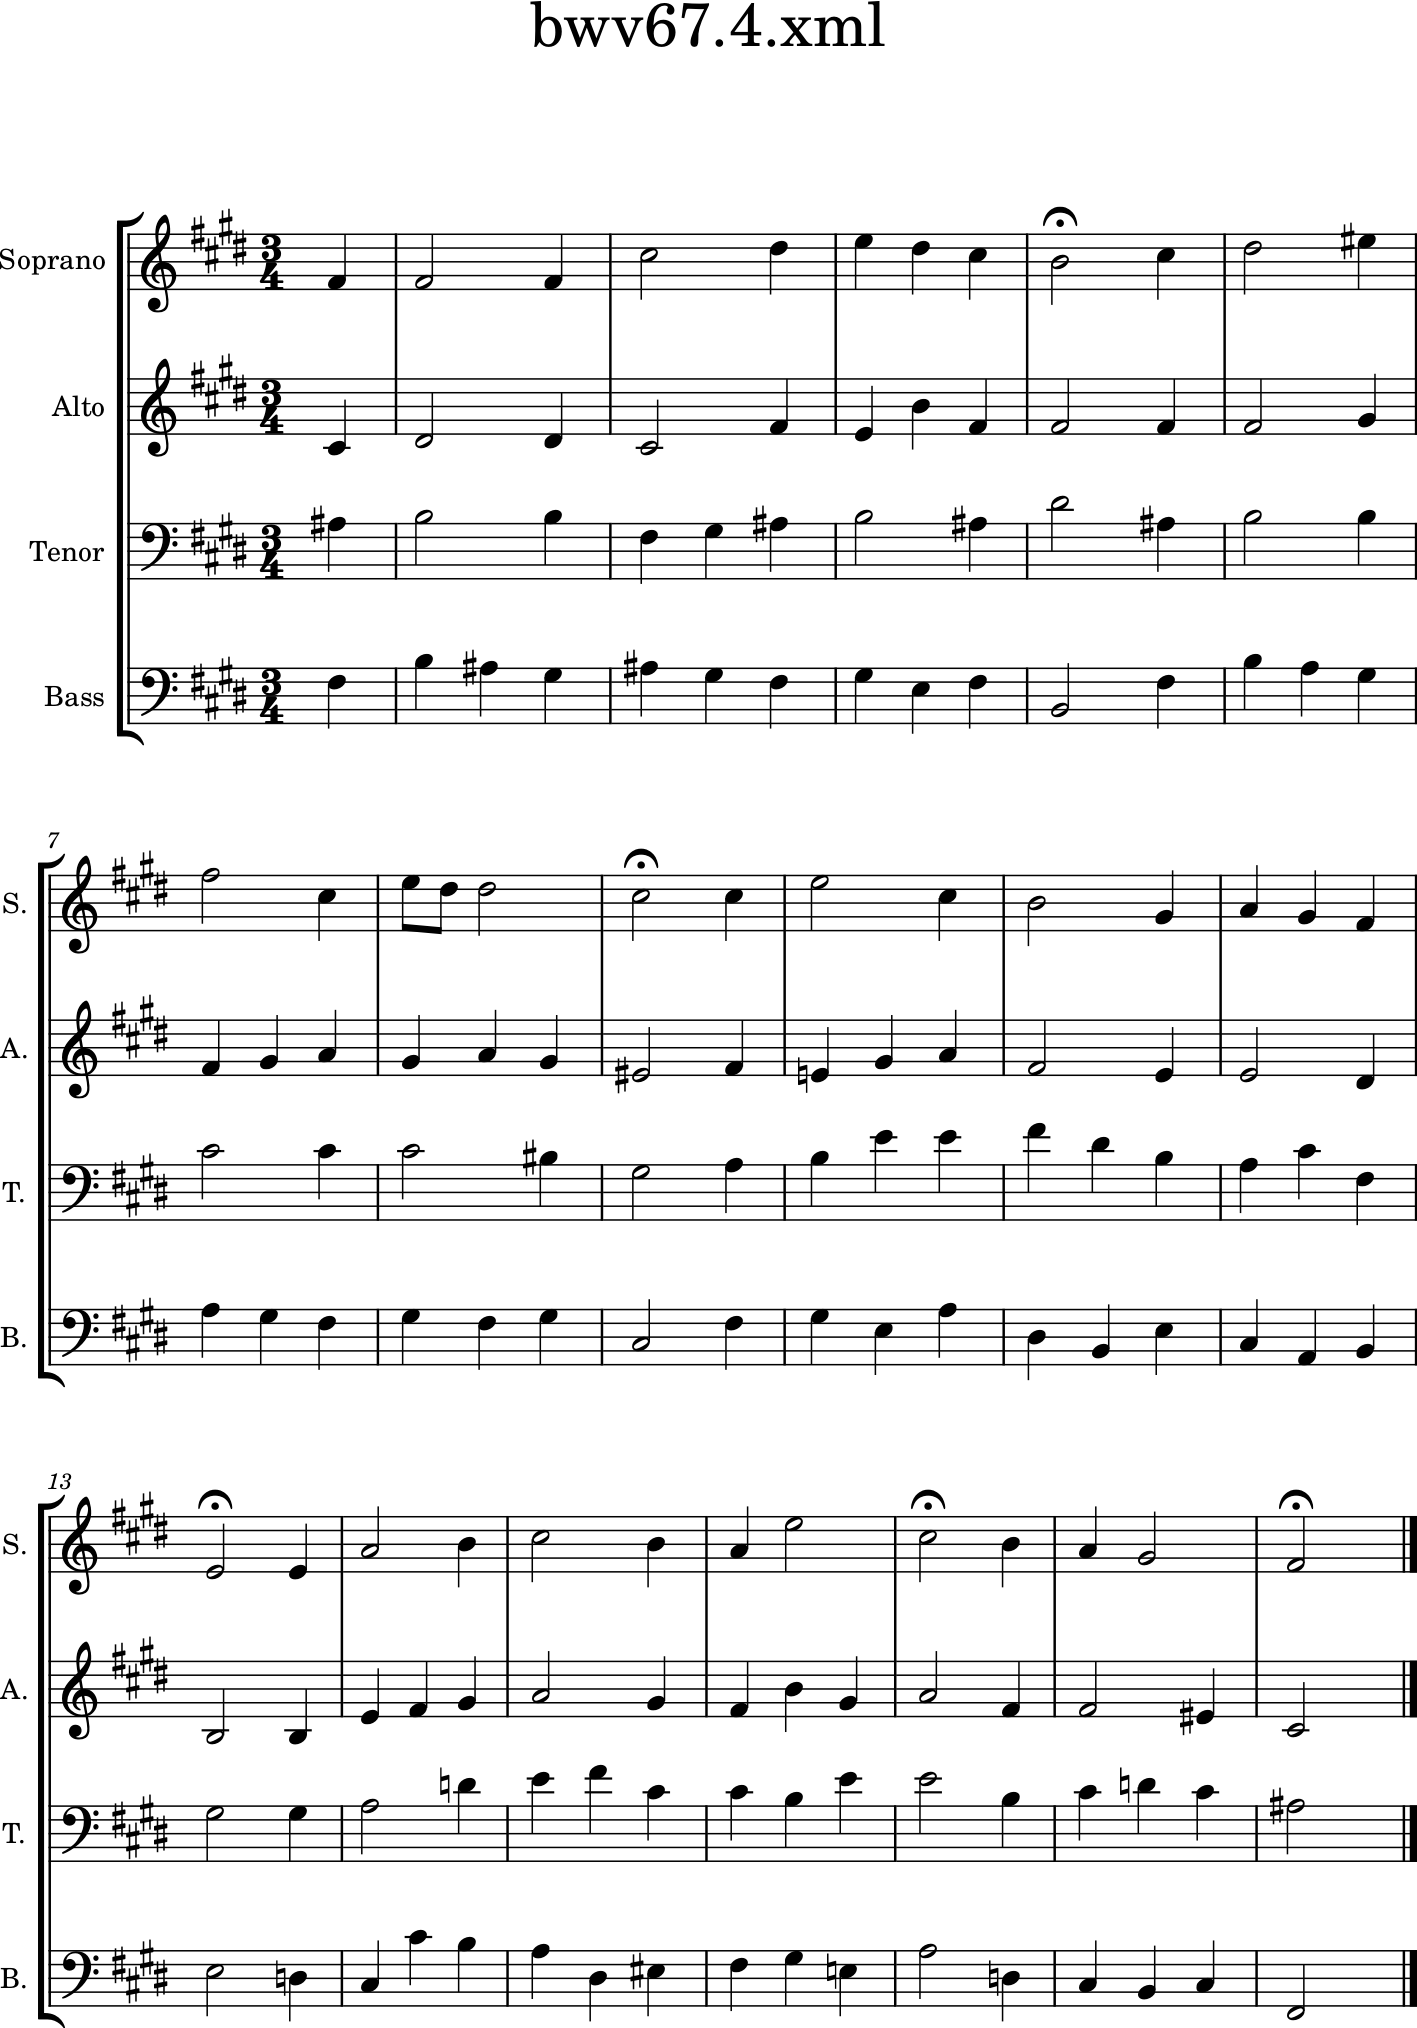

In [6]:
sBach = corpus.parse('bwv67.4')
sBach.show()

In [8]:
intervals_df,pnames,pnums = Utils.get_intervals_for_score(sBach)
notes_df,pnames,pnums = Utils.get_notes_for_score(sBach)

In [9]:
print("part_names: {},  \npart_numbers: {}".format(pnames,pnums))

part_names: {'Tenor', 'Soprano', 'Bass', 'Alto'},  
part_numbers: {1, 2, 3, 4}


In [10]:
print('len: {}  number of parts: {}'.format(len(sBach), len(sBach.parts)))
for sb in sBach.parts:
    print(sb, len(sb))

len: 6  number of parts: 4
<music21.stream.Part Soprano> 20
<music21.stream.Part Alto> 20
<music21.stream.Part Tenor> 20
<music21.stream.Part Bass> 20


In [15]:
soprano = sBach.parts[0]
alto = sBach.parts[1]
tenor = sBach.parts[2]
bass = sBach.parts[3]
soprano_measures = soprano.getElementsByClass('Measure')
print(len(soprano_measures))
i = 1
for measure in soprano_measures:
    notes = measure.getElementsByClass(['Note','Chord','Rest'])
    print('measure {}'.format(i))
    for n in notes:
        if n.isNote:
            print(n.nameWithOctave)
        else:
            print(n.fullName)
    #print(n.instrument)
    i = i+1
    measure.show('text')

19
measure 1
F#4
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.Key of E major>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.note.Note F#>
measure 2
F#4
F#4
{0.0} <music21.note.Note F#>
{2.0} <music21.note.Note F#>
measure 3
C#5
D#5
{0.0} <music21.note.Note C#>
{2.0} <music21.note.Note D#>
measure 4
E5
D#5
C#5
{0.0} <music21.note.Note E>
{1.0} <music21.note.Note D#>
{2.0} <music21.note.Note C#>
measure 5
B4
C#5
{0.0} <music21.note.Note B>
{2.0} <music21.note.Note C#>
measure 6
D#5
E#5
{0.0} <music21.note.Note D#>
{2.0} <music21.note.Note E#>
measure 7
F#5
C#5
{0.0} <music21.layout.SystemLayout>
{0.0} <music21.note.Note F#>
{2.0} <music21.note.Note C#>
measure 8
E5
D#5
D#5
{0.0} <music21.note.Note E>
{0.5} <music21.note.Note D#>
{1.0} <music21.note.Note D#>
measure 9
C#5
C#5
{0.0} <music21.note.Note C#>
{2.0} <music21.note.Note C#>
measure 10
E5
C#5
{0.0} <music21.note.Note E>
{2.0} <music21.note.Note C#>
measure 11
B4
G#4
{0.0} <music21.note.Note B>
{2.0} <music21.note.No

In [10]:
len(soprano.flat)

46

In [11]:
# or all the Notes in a Part along with the durations
soprano_notes = soprano.flat.getElementsByClass('Note')
print(len(soprano_notes))
for x in soprano_notes:
    print('{} {}'.format(x.nameWithOctave,x.duration.type))

39
F#4 quarter
F#4 half
F#4 quarter
C#5 half
D#5 quarter
E5 quarter
D#5 quarter
C#5 quarter
B4 half
C#5 quarter
D#5 half
E#5 quarter
F#5 half
C#5 quarter
E5 eighth
D#5 eighth
D#5 half
C#5 half
C#5 quarter
E5 half
C#5 quarter
B4 half
G#4 quarter
A4 quarter
G#4 quarter
F#4 quarter
E4 half
E4 quarter
A4 half
B4 quarter
C#5 half
B4 quarter
A4 quarter
E5 half
C#5 half
B4 quarter
A4 quarter
G#4 half
F#4 half


In [7]:
# or all the Notes in the tenor Part along with the durations
tenor_notes = tenor.flat.getElementsByClass('Note')
print(len(tenor_notes))
for x in tenor_notes:
    # print('{} {}'.format(x.nameWithOctave,x.duration.type))
    pass

43


## [Intervals](https://web.mit.edu/music21/doc/usersGuide/usersGuide_18_intervals.html)

In [8]:
# get the intervals in the tenor part
for ind in range(len(tenor_notes)-1):
    n1 = tenor_notes[ind]
    n2 = tenor_notes[ind+1]
    i = interval.Interval(n1, n2)
    print('{}\t{}\tsteps: {}\t{}\t{}\t{}'.format(n1.nameWithOctave, n2.nameWithOctave, i.semitones, 
                                             i.name, i.directedName, i.niceName))
    

A#3	B3	steps: 1	m2	m2	Minor Second
B3	B3	steps: 0	P1	P1	Perfect Unison
B3	F#3	steps: -5	P4	P-4	Perfect Fourth
F#3	G#3	steps: 2	M2	M2	Major Second
G#3	A#3	steps: 2	M2	M2	Major Second
A#3	B3	steps: 1	m2	m2	Minor Second
B3	A#3	steps: -1	m2	m-2	Minor Second
A#3	D#4	steps: 5	P4	P4	Perfect Fourth
D#4	A#3	steps: -5	P4	P-4	Perfect Fourth
A#3	B3	steps: 1	m2	m2	Minor Second
B3	B3	steps: 0	P1	P1	Perfect Unison
B3	C#4	steps: 2	M2	M2	Major Second
C#4	C#4	steps: 0	P1	P1	Perfect Unison
C#4	C#4	steps: 0	P1	P1	Perfect Unison
C#4	B#3	steps: -1	m2	m-2	Minor Second
B#3	G#3	steps: -4	M3	M-3	Major Third
G#3	A3	steps: 1	m2	m2	Minor Second
A3	B3	steps: 2	M2	M2	Major Second
B3	E4	steps: 5	P4	P4	Perfect Fourth
E4	E4	steps: 0	P1	P1	Perfect Unison
E4	F#4	steps: 2	M2	M2	Major Second
F#4	D#4	steps: -3	m3	m-3	Minor Third
D#4	B3	steps: -4	M3	M-3	Major Third
B3	A3	steps: -2	M2	M-2	Major Second
A3	C#4	steps: 4	M3	M3	Major Third
C#4	F#3	steps: -7	P5	P-5	Perfect Fifth
F#3	G#3	steps: 2	M2	M2	Major Second
G#3	G#3	steps: 0	

In [29]:
corpus.search('bach','composer')

<music21.metadata.bundles.MetadataBundle {363 entries}>

In [9]:
sBach = corpus.parse('bwv29.8')
intervals_df,pname,pnums = Utils.get_intervals_for_score(sBach)

In [10]:
intervals_df[['name','directedName','niceName','semitones','part_name','part_number']]

,name,directedName,niceName,semitones,part_name,part_number
0,P5,P-5,Perfect Fifth,-7,Trumpet 1,1
1,P4,P4,Perfect Fourth,5,Trumpet 1,1
2,m2,m-2,Minor Second,-1,Trumpet 1,1
3,M2,M-2,Major Second,-2,Trumpet 1,1
4,m3,m3,Minor Third,3,Trumpet 1,1
...,...,...,...,...,...,...
10,P4,P-4,Perfect Fourth,-5,Timpani,8
11,P1,P1,Perfect Unison,0,Timpani,8
12,P4,P4,Perfect Fourth,5,Timpani,8
13,P4,P-4,Perfect Fourth,-5,Timpani,8


In [40]:
int_df = intervals_df.groupby(by=['semitones']).count()[['interval']]
int_df.rename(columns={'interval':'count'}, inplace=True)
int_df.reset_index(inplace=True)

In [41]:
int_df.sort_values(by='count', ascending=False)

,semitones,count
6,-2,127
10,2,77
8,0,76
7,-1,63
13,5,42
9,1,41
1,-7,16
3,-5,13
5,-3,10
4,-4,9


In [42]:
mb1 = corpus.search('bwv*','title')
mb2 = corpus.search('bach','composer')
mb3 = mb1.intersection(mb2)

In [43]:
mb1

<music21.metadata.bundles.MetadataBundle {410 entries}>

In [14]:
df, pnames,pnums = Utils.get_all_score_intervals(composer='bach',title='bwv31*')

In [16]:
df['semitones']

0     0
1     0
2    -3
3     2
4     1
     ..
48    2
49    1
50    2
51    0
52   -7
Name: semitones, Length: 25233, dtype: int64

In [3]:
md = Utils.get_metadata_bundle('bach','bwv31*')
len(md)

107

In [17]:
idf = df.iloc[2:4]
idf['name'].values.tolist()

['m3', 'M2']

In [20]:
print(Utils.show_intervals(idf,'name'))
intervals = Utils.show_intervals(idf,'semitones')
print(intervals)
# print(show_intervals([df.iloc[2:4]],'directedName'))
#print(df.iloc[2:4]['name'].values.tolist())
#print(df.iloc[2:4]['semitones'].values.tolist())
#intervals = df.iloc[2:4]
#str(intervals['semitones'].values.tolist())
intervals.replace(' ','')

['m3', 'M2']
[-3, 2]


'[-3,2]'

In [51]:
interval = df.iloc[3]
print(f"{df.iloc[2]['name']}")
print(f"{df.iloc[2]['semitones']}")

m3
-3


In [52]:
int_df = df.groupby(by=['semitones']).count()[['interval']]
int_df.rename(columns={'interval':'count'}, inplace=True)
int_df.reset_index(inplace=True)

In [53]:
int_df.sort_values(by='count', ascending=False)

,semitones,count
12,-2,5364
16,2,4530
14,0,3638
13,-1,3410
15,1,2883
19,5,1370
10,-4,703
7,-7,637
11,-3,622
9,-5,470


In [66]:
n1 = note.Note('A0')
n2 = note.Note('C8')
aInterval = interval.Interval(n1,n2)
print(aInterval.name)
print(aInterval.directedName)
print(aInterval.semitones)

m52
m52
87


In [3]:
terminal_object = interval.Interval(100)
initial_object = interval.Interval(99)
initial_dict = {'interval':initial_object, 'name':initial_object.name, 'directedName':initial_object.directedName,\
                        'niceName':initial_object.niceName, 'semitones':initial_object.semitones, 'part_number':1, 'part_name':'rest'}
initial_object_df = pd.DataFrame(data=initial_dict, index=[0]) 

In [7]:
initial_object.semitones

99

## [Notes](https://web.mit.edu/music21/doc/moduleReference/moduleNote.html)


In [8]:
sBach = corpus.parse('bwv67.4')
sBach

<music21.stream.Score 0x244cad4c040>

In [10]:
notes_df,pnames,pnums = Utils.get_notes_for_score(sBach)
print("part_names: {},  \npart_numbers: {}".format(pnames,pnums))

part_names: {'Bass', 'Soprano', 'Tenor', 'Alto'},  
part_numbers: {1, 2, 3, 4}


In [30]:
terminal_object = note.Rest()
terminal_object.duration.quarterLength=24
initial_object = note.Rest()
initial_object.duration.quarterLength=0
partNotes_df = notes_df[notes_df['part_name']=='Soprano']
partNotes_df.head()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38],
           dtype='int64')

In [21]:
initial_object.name

'rest'

In [36]:
initial_dict = {'note':initial_object, 'part_number':1, 'part_name':'rest', 
               'nameWithOctave':'rest', 'pitch':'', 'duration':initial_object.duration, 
                'pitchClass':0, 'name':'rest'}
initial_df = pd.DataFrame(data=initial_dict, index=[0])
initial_df.append(partNotes_df[0:1])
initial_df.iloc[0]

note                     <music21.note.Rest zero>
part_number                                     1
part_name                                    rest
nameWithOctave                               rest
pitch                                            
duration          <music21.duration.Duration 0.0>
pitchClass                                      0
name                                         rest
Name: 0, dtype: object

In [39]:
notes_df[['note','duration']]

,note,duration
0,<music21.note.Note F#>,<music21.duration.Duration 1.0>
1,<music21.note.Note F#>,<music21.duration.Duration 2.0>
2,<music21.note.Note F#>,<music21.duration.Duration 1.0>
3,<music21.note.Note C#>,<music21.duration.Duration 2.0>
4,<music21.note.Note D#>,<music21.duration.Duration 1.0>
...,...,...
44,<music21.note.Note D>,<music21.duration.Duration 1.0>
45,<music21.note.Note C#>,<music21.duration.Duration 1.0>
46,<music21.note.Note B>,<music21.duration.Duration 1.0>
47,<music21.note.Note C#>,<music21.duration.Duration 1.0>


In [43]:
durations_df = Utils.get_durations_from_notes(notes_df)
durations_df

,note,duration,type,ordinal,dots,fullName,quarterLength,tuplets
0,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
1,<music21.note.Note F#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
2,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
3,<music21.note.Note C#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
4,<music21.note.Note D#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
...,...,...,...,...,...,...,...,...
44,<music21.note.Note D>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
45,<music21.note.Note C#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
46,<music21.note.Note B>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
47,<music21.note.Note C#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()


In [45]:
# parse a single music xml file
# 
score = converter.parse('/compile/dwbzen/resources/music/Prelude.mxl')
len(score.parts)

2

In [46]:
print('len: {}  number of parts: {}'.format(len(score), len(score.parts)))
for sb in score.parts:
    print(sb, len(sb))

len: 10  number of parts: 2
<music21.stream.PartStaff P1-Staff1> 40
<music21.stream.PartStaff P1-Staff2> 21


In [48]:
intervals_df,pnames,pnums = Utils.get_intervals_for_score(score)
intervals_df
print(pnames)
print(pnums)

{'Piano'}
{1}


In [51]:
stats_df = Utils.get_interval_stats(score)
stats_df

,semitones,count
15,-2,13
20,3,9
10,-7,9
21,4,8
19,2,6
17,0,6
16,-1,6
13,-4,5
24,7,5
14,-3,4


In [163]:
stats_df.apply(np.sum, axis=0)    # sum the columns (along the rows)

semitones      3
count        120
dtype: int64